In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import numpy as np
import pandas as pd

In [2]:
import mlflow
from mlflow.models import infer_signature

import os
import math
import seaborn as sns
from tqdm.notebook import tqdm, trange

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LOOKBACK = 5
HORIZON = 1

In [4]:
sns.set_theme('paper', rc={'figure.figsize': (16, 4)})

torch.manual_seed(42)

mlflow.set_experiment("Stock Market Predictions")
mlflow.start_run(run_name="Baseline")

<ActiveRun: >

In [5]:
DATA_FILE = 'SSEC.csv'
df = pd.read_csv(f'../data/{DATA_FILE}', index_col='Date')
data = df['Close'].values

mlflow.log_param("Dataset", DATA_FILE)

'SSEC.csv'

In [6]:
train_size = int(0.7*len(data))
val_size = int(0.15*len(data))
test_size = len(data) - train_size - val_size

mlflow.log_param("Train Size", train_size)
mlflow.log_param("Validation Size", val_size)
mlflow.log_param("Test Size", test_size)

data_train, data_val, data_test = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

In [7]:
data_train.shape, data_val.shape, data_test.shape

((2382,), (510,), (511,))

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))

data_train = torch.FloatTensor(scaler.fit_transform(data_train.reshape(-1, 1))).to(DEVICE)
data_val = torch.FloatTensor(scaler.transform(data_val.reshape(-1, 1))).to(DEVICE)
data_test = torch.FloatTensor(scaler.transform(data_test.reshape(-1, 1))).to(DEVICE)

In [9]:
data_train.size(), data_val.size(), data_test.size()

(torch.Size([2382, 1]), torch.Size([510, 1]), torch.Size([511, 1]))

In [10]:
X_train = data_train.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_train = data_train[LOOKBACK:]

X_val = data_val.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_val = data_val[LOOKBACK:]

X_test = data_test.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_test = data_test[LOOKBACK:]

In [11]:
# (N,L,H_in​) 
X_train.size(), y_train.size(), X_val.size(), y_val.size(), X_test.size(), y_test.size()

(torch.Size([2377, 1, 5]),
 torch.Size([2377, 1]),
 torch.Size([505, 1, 5]),
 torch.Size([505, 1]),
 torch.Size([506, 1, 5]),
 torch.Size([506, 1]))

In [12]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
    
    def forward(self, x):       
        return x[:,:,-1]

In [13]:
model = Baseline() 
model.to(DEVICE)

Baseline()

In [14]:
params = {
    "Lookback": LOOKBACK,
    "Horizon": HORIZON,
    "Scaler": type(scaler).__name__,
}

mlflow.log_params(params)

In [15]:
if os.path.exists(f'../models/{type(model).__name__}.pt'):    
    model.load_state_dict(torch.load(f"../models/{type(model).__name__}.pt"))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

y_pred_inv = scaler.inverse_transform(y_pred.cpu().detach().numpy()).flatten()
y_test_inv = scaler.inverse_transform(y_test.cpu().detach().numpy()).flatten()

mlflow.pytorch.log_model(
    registered_model_name="Baseline",
    artifact_path="Baseline",
    pytorch_model=model,
    input_example = X_test.cpu().detach().numpy(),
    signature=infer_signature(X_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
)

Successfully registered model 'Baseline'.
2025/02/25 10:11:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Baseline, version 1
Created version '1' of model 'Baseline'.


<Axes: xlabel='Date'>

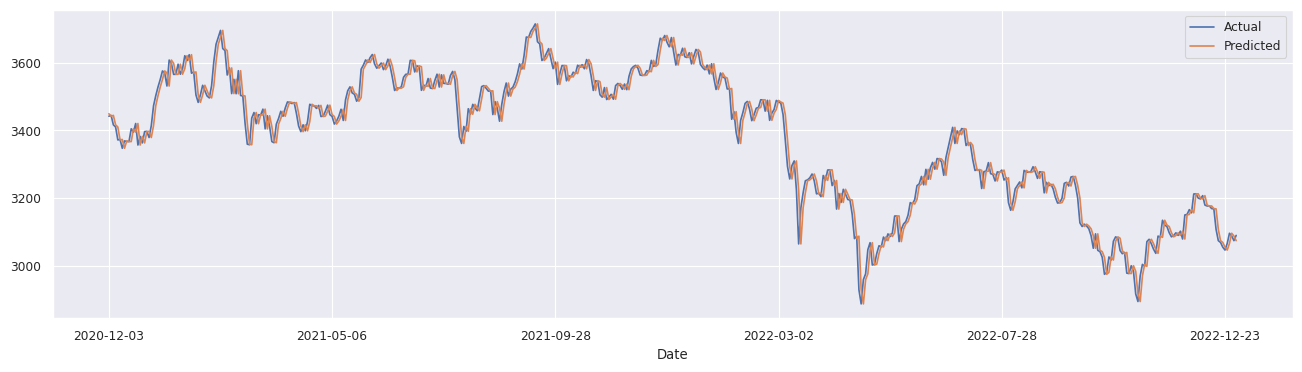

In [16]:
pd.DataFrame([y_test_inv, y_pred_inv], index=['Actual', 'Predicted'], columns=df.index[-len(X_test):]).T.plot()

In [17]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(y_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_pred_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric("Test MAE", mae)
mlflow.log_metric("Test MSE", mse)
mlflow.log_metric("Test RMSE", rmse)

print(f"Test MAE: {mae:.4f}  Test MSE: {mse:.4f} Test RMSE: {rmse:.4f}")

Test MAE: 25.0034  Test MSE: 1112.7211 Test RMSE: 33.3575


In [18]:
model.eval()
y_recursive = []

# Start with the first element of X_test
current_input = X_test[0].unsqueeze(0)

with torch.no_grad():
    for _ in range(len(X_test)):
        output = model(current_input).unsqueeze(0)
        y_recursive.append(output.cpu().numpy())

        # Prepare the next input by appending the prediction to the current input and removing the oldest value
        current_input = torch.cat((current_input[:, :, 1:], output), dim=2)

y_recursive = np.concatenate(y_recursive, axis=1).squeeze()
y_recursive_inv = scaler.inverse_transform(y_recursive.reshape(-1, 1)).flatten()

<Axes: xlabel='Date'>

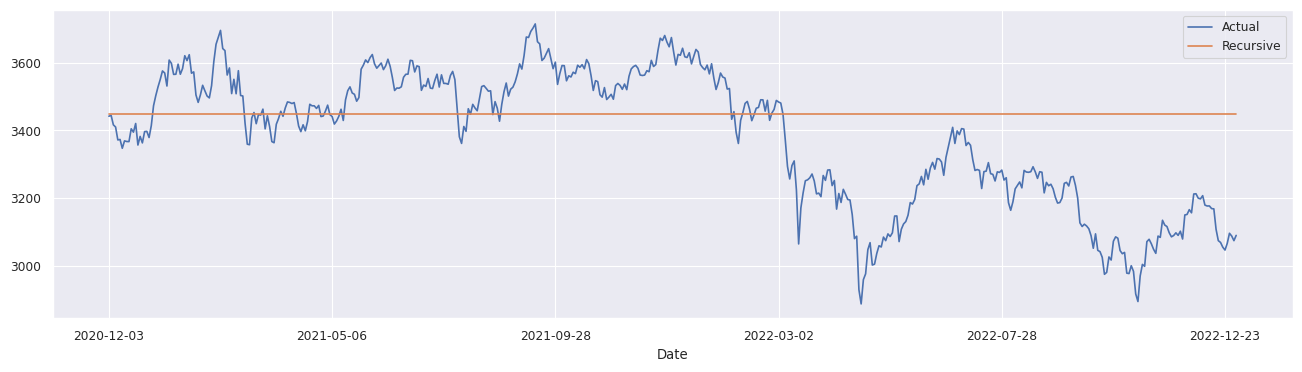

In [19]:
pd.DataFrame([y_test_inv, y_recursive_inv], index=['Actual', 'Recursive'], columns=df.index[-len(X_test):]).T.plot()

In [20]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_recursive_inv, y_test_inv)
mse = metrics.mean_squared_error(y_recursive_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_recursive_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric("Recursive Test MAE", mae)
mlflow.log_metric("Recursive Test MSE", mse)
mlflow.log_metric("Recursive Test RMSE", rmse)
mlflow.end_run()

print(f"Recursive MAE: {mae:.4f} Recursive MSE: {mse:.4f} Recursive RMSE: {rmse:.4f}")

🏃 View run Baseline at: http://stock-market-mlflow-1:5000/#/experiments/413500972837603300/runs/d0bdca0b63b9448db8e5bb5c07c9b5ee
🧪 View experiment at: http://stock-market-mlflow-1:5000/#/experiments/413500972837603300
Recursive MAE: 165.6979 Recursive MSE: 42911.6953 Recursive RMSE: 207.1514


In [21]:
# Get predictions on the training dataset
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.cpu().detach().numpy()).flatten()
y_train_inv = scaler.inverse_transform(y_train.cpu().detach().numpy()).flatten()

<Axes: xlabel='Date'>

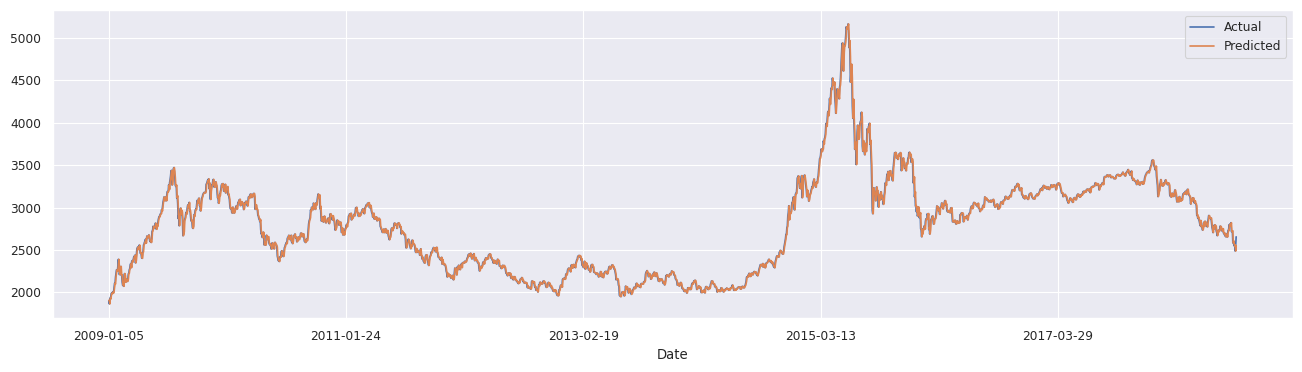

In [22]:
pd.DataFrame([y_train_inv, y_train_pred_inv], index=['Actual', 'Predicted'], columns=df.index[:len(X_train)]).T.plot()

In [23]:
# Evaluate the model on the training dataset
mae = metrics.mean_absolute_error(y_train_pred_inv, y_train_inv)
mse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv)
rmse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv) ** 0.5

print(f"Train MAE: {mae:.4f} Train MSE: {mse:.4f} Train RMSE: {rmse:.4f}")

Train MAE: 28.2330 Train MSE: 2001.5698 Train RMSE: 44.7389
